# LSTM Time Series Example

> Note: This tutorial is based on [Time Series Forecasting with the Long Short-Term Memory Network in Python](http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/) by Jason Brownlee.


## Part 2 - Train LSTM 

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [25]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

dataset = read_csv('../data/yellowstone-visitors-ur-weather.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
dataset.head()

,visitors,unemployment,TMAX,TMIN,TAVG,PRCP
month,,,,,,
1990-01-01,25884,5.4,44,-5,26.9,8.8
1990-02-01,33285,5.3,50,-14,23.3,6.3
1990-03-01,19372,5.2,56,2,32.6,2.9
1990-04-01,29242,5.4,68,11,40.2,5.4
1990-05-01,203712,5.4,67,12,41.8,4.0


In [34]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

diff_values = difference(dataset.values)
diff_df = DataFrame(diff_values, columns=dataset.columns.values)
diff_df.head()

,visitors,unemployment,TMAX,TMIN,TAVG,PRCP
0,7401.0,-0.1,6.0,-9.0,-3.6,-2.5
1,-13913.0,-0.1,6.0,16.0,9.3,-3.4
2,9870.0,0.2,12.0,9.0,7.6,2.5
3,174470.0,0.0,-1.0,1.0,1.6,-1.4
4,322874.0,-0.2,20.0,19.0,12.9,-2.3


In [48]:
labels = diff_df['visitors'].rename(index='label')
shifted = diff_df.shift(1)
supervised = concat([shifted, labels], axis=1)
supervised.fillna(0, inplace=True)
supervised.head()

,visitors,unemployment,TMAX,TMIN,TAVG,PRCP,label
0,0.0,0.0,0.0,0.0,0.0,0.0,7401.0
1,7401.0,-0.1,6.0,-9.0,-3.6,-2.5,-13913.0
2,-13913.0,-0.1,6.0,16.0,9.3,-3.4,9870.0
3,9870.0,0.2,12.0,9.0,7.6,2.5,174470.0
4,174470.0,0.0,-1.0,1.0,1.6,-1.4,322874.0


In [57]:
supervised_values = supervised.values
train, test = supervised_values[0:-12], supervised_values[-12:]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train = train.reshape(train.shape[0], train.shape[1])
train_scaled = scaler.transform(train)

test = test.reshape(test.shape[0], test.shape[1])
test_scaled = scaler.transform(test)

print('training set shape: {}'.format(train_scaled.shape))
print(train_scaled[0])

training set shape: (311, 7)
[  6.90947787e-02  -8.88178420e-16   1.60000000e-01   1.09703800e-03
   5.91133005e-02  -1.14754098e-01   8.45981350e-02]


In [54]:
batch_size = 1 # required for stateful LSTM
neurons = 6 
features = 6
labels = 1

model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, 1, features), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
nb_epoch = 300

X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

In [84]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

array([ 25884,  33285,  19372,  29242, 203712, 526586, 760520, 674454,
       414563, 111145,   8117,  16692,  28851,  38050,  19946,  19875,
       188798, 499107, 796656, 721103, 432948, 144944,   6261,  23998,
        33552,  40245,  19615,  51933, 257951, 539959, 799411, 742879,
       462788, 159842,   8646,  27584,  38100,  44049,  31768,  24013,
       191222, 525378, 768164, 714408, 401124, 125107,  18899,  29961,
        40757,  44946,  27859,  36280, 233737, 541704, 831152, 731012,
       414848, 106646,   7953,  29251,  40868,  48034,  21157,  26147,
       201797, 550978, 847003, 773307, 468062, 128483,  11635,   7814,
        32871,  51692,  27162,  24321, 187045, 539368, 818964, 753934,
       426806, 118902,  10473,  20633,  31155,  42392,  19324,  21526,
       191985, 512895, 774327, 737973, 403184, 120266,   9983,  24503,
        33845,  43032,  17894,  29689, 222385, 549396, 829683, 764238,
       445741, 150079,   9106,  25742,  34346,  41120,  23067,  27128,
      

In [87]:
visitor_history = dataset['visitors'].values

predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    X = X.reshape(1, 1, len(X))
    scaled_pred = model.predict(X, batch_size=batch_size)
    
    visitor_delta = invert_scale(scaler, X[0,0], scaled_pred[0,0])
    prev_mon_vistitor = visitor_history[-len(test_scaled)+1-i]
    
    predictions.append(prev_mon_vistitor + visitor_delta)


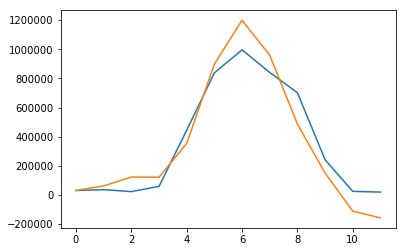

In [88]:
pyplot.plot(visitor_history[-12:])
pyplot.plot(predictions)
pyplot.show()